In [1]:
import torchOptics.optics as tt
import warnings
import torch.nn as nn
import torchOptics.metrics as tm
import torch.nn.functional as F
import torch.optim
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision
import datetime
import tqdm
import time
import HHS.model


warnings.filterwarnings('ignore')


class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        t = torch.Tensor([0.5]).cuda()  # threshold
        output = (input > t).float() * 1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input


class Dataset512(Dataset):
    def __init__(self, target_dir, meta, transform=None, isTrain=True):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.isTrain = isTrain
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.center_crop = torchvision.transforms.CenterCrop(512)
        self.random_crop = torchvision.transforms.RandomCrop((512, 512))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray=True)
        target = target.unsqueeze(0)
        if self.isTrain:
            target = self.random_crop(target)
        else:
            target = self.center_crop(target)
        return target


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

# load data
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl': (638e-9), 'dx': (6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=True)
valid_dataset = Dataset512(target_dir=valid_dir, meta=meta, isTrain=False)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


def train(model, num_hologram=10, custom_name='fcn', epochs=100, lr=1e-4, z=2e-3):
    date = datetime.datetime.now() - datetime.timedelta(hours=15)
    mean_psnr_list = []
    mean_mse_list = []
    max_epoch = 0
    max_psnr = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sign_function = SignFunction.apply
    # path = 'models/'
    model_name = f'{date}_{custom_name}_{num_hologram}_{z}'
    # make result folder
    result_folder = 'result/'+model_name
    os.mkdir(result_folder)
    model_path = os.path.join(result_folder, model_name)
    psnr_result_path = os.path.join(result_folder, 'meanPSNR.npy')
    mse_result_path = os.path.join(result_folder, 'meanMSE.npy')
    result = {'model_path': model_path, 'psnr_result_path': psnr_result_path,
          'mse_result_path': mse_result_path, 'z': z,
          'num_hologram': num_hologram, 'lr': lr, 'epochs': epochs}
    # save result dict
    with open(os.path.join(result_folder, 'result_dict.pickle'), 'wb') as fw:
        pickle.dump(result, fw)
    for epoch in range(epochs):
        pbar = tqdm.tqdm(trainloader)
        model.train()
        for target in pbar:
            out = model(target)
            binary = sign_function(out)
            sim = tt.simulate(binary, z).abs()**2
            result = torch.mean(sim, dim=1, keepdim=True)
            loss = tt.relativeLoss(result, target, F.mse_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            psnrList = []
            mseList = []
            for valid in validloader:
                out = model(valid)
                binary = sign_function(out)
                sim = tt.simulate(binary, z).abs()**2
                result = torch.mean(sim, dim=1, keepdim=True)
                psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
                psnrList.append(psnr)
                mse = tt.relativeLoss(result, valid, F.mse_loss).detach().cpu().numpy()
                mseList.append(mse)
            mean_psnr = sum(psnrList)/len(psnrList)
            mean_mse = sum(mseList)/len(mseList)
            mean_psnr_list.append(mean_psnr)
            mean_mse_list.append(mean_mse)
            # save psnr and mse
            np.save(psnr_result_path, mean_psnr_list)
            np.save(mse_result_path, mean_mse_list)
            plt.plot(np.arange(len(mean_psnr_list)), mean_psnr_list,
                     label=f'max psnr: {max(mean_psnr_list)}')
            plt.title(model_name+'_psnr')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanPSNR.png'))
            plt.clf()
            plt.plot(np.arange(len(mean_mse_list)), mean_mse_list,
                     label=f'max psnr: {min(mean_mse_list)}')
            plt.title(model_name+'_mse')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanMSE.png'))
            plt.clf()
            print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
            print(f'mean MSE : {mean_mse} {epoch}/{epochs}')

        if mean_psnr > max_psnr:
            max_psnr = mean_psnr
            max_epoch = epoch
            torch.save(model.state_dict(), model_path)
        print(f'max_psnr: {max_psnr}, epoch: {max_epoch}')


def binary_sim(out, z=2e-3):
    binary = SignFunction.apply(out)
    sim = tt.simulate(binary, z).abs()**2
    res = torch.mean(sim, dim=1, keepdim=True)
    return binary, res

def con_sim(out, z=2e-3):
    # binary = SignFunction.apply(out)
    sim = tt.simulate(out, z).abs()**2
    res = torch.mean(sim, dim=1, keepdim=True)
    return res

In [6]:
class DatasetCoherence(Dataset):
    def __init__(self, target_dir, meta, transform=None):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.target_list = sorted(glob.glob(target_dir+'*.npy'))
        self.eye_matrix = torch.eye(10)

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target_path = self.target_list[idx]
        label = target_path.split('_')[-1].split('.')[0]
        label = self.eye_matrix[int(label)]
        # label = int(label)
        label = torch.Tensor(label).cuda()
        target = np.load(target_path)
        target = tt.Tensor(target, meta=meta).cuda()
        target = target.unsqueeze(0)
        return target, label


batch_size = 1
binary_dir = 'dataset/He_Leaky_reOptimize_train_10_0.002/binary/'
meta = {'wl': (638e-9), 'dx': (6.3e-6, 6.3e-6)}
binary_dataset = DatasetCoherence(target_dir=binary_dir, meta=meta)
train_dataset, valid_dataset = random_split(binary_dataset, [800, 200])

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [3]:
model = HHS.model.FCN_Leakey(10, Tanh=False).cuda()
model.load_state_dict(torch.load('result/2024-04-06 00:17:57.680053_He_Leaky_10_0.002/2024-04-06 00:17:57.680053_He_Leaky_10_0.002'))
model.eval()

FCN_Leakey(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2),

In [4]:
loss_list = []
for target in validloader:
    out = model(target)
    binary, res = binary_sim(out)
    loss = tt.relativeLoss(res, target, tm.get_PSNR)
    loss_list.append(loss)
print(sum(loss_list)/len(loss_list))

24.39450689315796


In [5]:
model_co = HHS.model.FCN_Linear(10).cuda()
optimizer = torch.optim.Adam(model_co.parameters(), lr=1e-5)
eye_matrix = torch.eye(10)
for epoch in range(100):
    loss_list = []
    for target in tqdm.tqdm(trainloader):
        with torch.no_grad():
            out = model(target)
            binary, res = binary_sim(out)
            binary = binary.detach().requires_grad_()
        inter_loss_list = []
        for i in range(10):
            co_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            co_out = model_co(co_input)
            label = eye_matrix[i].unsqueeze(0).cuda()
            loss = F.cross_entropy(co_out, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            inter_loss_list.append(loss.detach().cpu().numpy())
        mean_inter_loss = sum(inter_loss_list)/len(inter_loss_list)
        loss_list.append(mean_inter_loss)
    print(sum(loss_list)/len(loss_list))

100%|██████████| 800/800 [05:19<00:00,  2.51it/s]


4.861722308117069


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.7377560621630775


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.1339942935393171


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.14473637244040208


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.08757773382315566


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.04790946752006623


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.03410357183247143


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.03829713851533468


100%|██████████| 800/800 [05:14<00:00,  2.55it/s]


0.02315034822271069


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.034185689410859046


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.03906419083173864


100%|██████████| 800/800 [05:14<00:00,  2.55it/s]


0.005983270726274744


100%|██████████| 800/800 [05:14<00:00,  2.55it/s]


1.4702012864376002e-06


100%|██████████| 800/800 [05:14<00:00,  2.55it/s]


0.01391239750384167


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.03541218321206105


100%|██████████| 800/800 [05:14<00:00,  2.55it/s]


0.005275468171746065


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.002307231289656436


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.021089961314946604


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.01272358470593735


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.005365548926656742


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.00404714208094697


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


1.50939649756765e-08


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


2.5629733499954457e-09


100%|██████████| 800/800 [05:14<00:00,  2.55it/s]


0.0


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.019846152818492932


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


0.013196814999228082


100%|██████████| 800/800 [05:14<00:00,  2.55it/s]


0.002254241287707429


100%|██████████| 800/800 [05:14<00:00,  2.55it/s]


4.457632530829869e-08


100%|██████████| 800/800 [05:13<00:00,  2.55it/s]


2.7789220666818438e-08


 65%|██████▌   | 522/800 [03:24<01:49,  2.55it/s]


KeyboardInterrupt: 

In [11]:
torch.save(model_co.state_dict(), 'result/2024-04-10 coherence_classifier_test/coherence_classifier')

In [16]:
label.unsqueeze(0).shape

torch.Size([1, 10])

In [7]:
binary[0][0].shape

torch.Size([512, 512])

In [7]:
for target in trainloader:
    binary, label = target
    out = model_co(binary)
    loss = F.cross_entropy(out, label)
    print(loss)

-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


In [47]:
binary, label = valid_dataset[4]
out = model(binary.unsqueeze(0))
print(out[0])
print(label)

[-31913.436   -3088.583    4961.1772  19695.637   15893.929  -16506.135
  -7844.04    11244.9375   4825.149  -14971.476 ]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')


In [30]:
label.shape

torch.Size([1, 1])

In [19]:
indices = torch.tensor([1, 2, 0, 1, 2])

# 클래스의 총 수 (One-Hot 벡터의 길이)를 지정합니다.
num_classes = 3

# One-Hot 인코딩을 위한 대각 행렬을 생성합니다.
eye_matrix = torch.eye(num_classes)

# 정수 인덱스를 One-Hot 벡터로 변환합니다.
one_hot_encoded = eye_matrix[indices]
one_hot_encoded

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [25]:
logits = torch.tensor([[1.5, 0.5, 0.1]])  # 세 번째 샘플의 로짓

targets = torch.tensor([0])  # 각 샘플의 정답 레이블 (클래스 인덱스)

# cross_entropy() 함수를 사용하여 손실을 계산합니다.
loss = nn.functional.cross_entropy(logits, targets)

print("Cross-Entropy Loss:", loss.item())

Cross-Entropy Loss: 0.4790106415748596


In [4]:
input = valid_dataset[0].unsqueeze(0)
out = model(input)
binary, res = binary_sim(out)


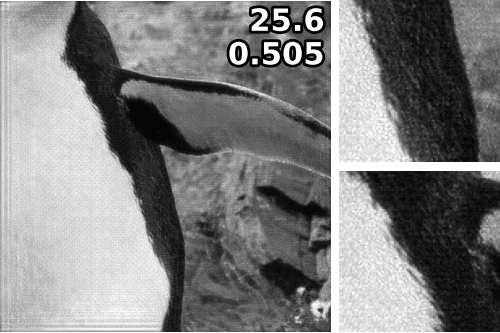

In [5]:
tt.show_with_insets(res, input)

In [7]:
model_co = HHS.model.FCN_Linear(10).cuda()
model_co.load_state_dict(torch.load('result/2024-04-10 coherence_classifier_test/coherence_classifier'))
model_co.eval()

FCN_Linear(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2),

In [42]:
out = model(input)
with torch.no_grad():
    out = out.detach().requires_grad_()
optimizer = torch.optim.Adam([out], lr=1e-4)
eye_matrix = torch.eye(10)
epochs = 1000
loss_list_tot = []
for epoch in range(epochs):
    loss_list = []
    binary, res = binary_sim(out)
    for i in range(10):
        co_input = binary[0][i].unsqueeze(0).unsqueeze(0)
        co_out = model_co(co_input)
        label = eye_matrix[i].unsqueeze(0).cuda()
        loss_co = F.cross_entropy(co_out, label)
        loss_list.append(loss_co)
    loss_im = tt.relativeLoss(res, input, F.mse_loss)
    loss_list.append(loss_im)
    loss = sum(loss_list)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list_tot.append(loss.detach().cpu().numpy())
    print(loss)

462.0763244628906
455.17181396484375
448.5494384765625
442.1466369628906
434.2226257324219
427.9704895019531
423.055419921875
416.8192138671875
409.99951171875
404.6524353027344
399.84161376953125
396.60321044921875
392.89044189453125
389.0693359375
385.0914611816406
381.4488525390625
377.6698303222656
374.255615234375
371.2158203125
366.92584228515625
363.5462951660156
360.0880126953125
357.0239562988281
352.7440185546875
348.9345397949219
344.8290100097656
341.6958312988281
337.55609130859375
333.119140625
329.1822509765625
325.9617919921875
322.0453796386719
318.3897705078125
314.3564758300781
309.9253234863281
306.28790283203125
302.6188049316406
299.53582763671875
295.3417053222656
290.98931884765625
286.6410217285156
282.2471008300781
279.0752868652344
275.7738342285156
273.2319030761719
271.04229736328125
269.15234375
267.47076416015625
265.4310607910156
262.8968200683594
260.7420959472656
258.81005859375
255.9865264892578
252.4971466064453
249.99395751953125
247.21347045898438


KeyboardInterrupt: 

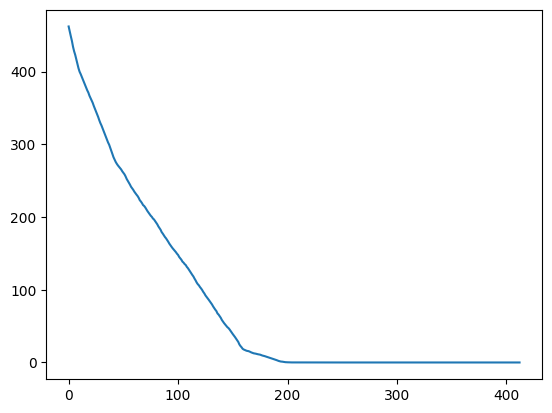

In [43]:
plt.plot(np.arange(len(loss_list_tot)), loss_list_tot)
plt.show()


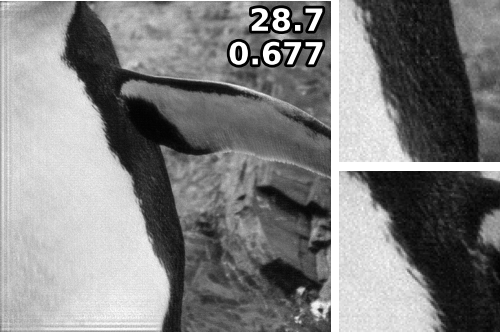

In [44]:
binary, res = binary_sim(out)
tt.show_with_insets(res, input)

In [50]:
binary_co = binary
for i in range(10):
    co_input = binary_co[0][i].unsqueeze(0).unsqueeze(0)
    co_out = model_co(co_input)
    label = eye_matrix[i].unsqueeze(0).cuda()
    loss_co = F.cross_entropy(co_out, label)
    print(torch.argmax(co_out[0]))

0
1
2
3
4
5
6
7
8
9


In [51]:
out = model(input)
with torch.no_grad():
    out = out.detach().requires_grad_()
optimizer = torch.optim.Adam([out], lr=1e-4)
eye_matrix = torch.eye(10)
epochs = 1000
loss_list_tot = []
for epoch in range(epochs):
    loss_list = []
    binary, res = binary_sim(out)
    # for i in range(10):
    #     co_input = binary[0][i].unsqueeze(0).unsqueeze(0)
    #     co_out = model_co(co_input)
    #     label = eye_matrix[i].unsqueeze(0).cuda()
    #     loss_co = F.cross_entropy(co_out, label)
    #     loss_list.append(loss_co)
    loss_im = tt.relativeLoss(res, input, F.mse_loss)
    # loss_list.append(loss_im)
    # loss = sum(loss_list)
    optimizer.zero_grad()
    loss_im.backward()
    optimizer.step()
    # loss_list_tot.append(loss.detach().cpu().numpy())
    print(loss)

0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.0029390789568424225
0.00293907

KeyboardInterrupt: 


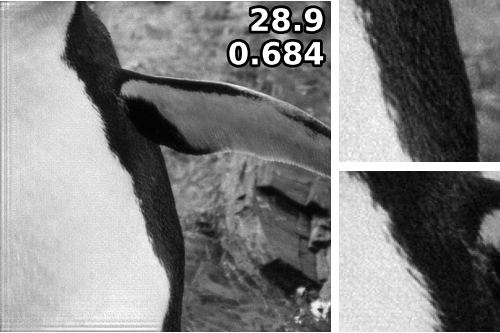

In [52]:
binary, res = binary_sim(out)
tt.show_with_insets(res, input)

In [ ]:
binary

In [41]:
for i in range(10):
    co_input = binary[0][i].unsqueeze(0).unsqueeze(0)
    co_out = model_co(co_input)
    label = eye_matrix[i].unsqueeze(0).cuda()
    loss_co = F.cross_entropy(co_out, label)
    print(loss_co)

-0.0
57.50981140136719
-0.0
-0.0
94.70278930664062
39.9390869140625
-0.0
-0.0
-0.0
299.0795593261719
